# Severstal Steel Defect Detection

This notebook implements a solution for the Severstal Steel Defect Detection competition. The goal is to localize and classify surface defects on steel sheets using semantic segmentation.

## Competition Overview
- **Task**: Semantic segmentation of steel defects
- **Evaluation Metric**: Mean Dice Coefficient
- **Classes**: 4 different types of defects
- **Output Format**: Run-Length Encoded (RLE) pixel masks

## Approach
1. Data loading and preprocessing with RLE decoding
2. U-Net based segmentation model
3. Data augmentation using Albumentations
4. Dice Loss for training
5. RLE encoding for submission

In [30]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Segmentation Models
import segmentation_models_pytorch as smp

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utilities
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [31]:
# Configuration
class Config:
    # Paths
    DATA_PATH = r'D:\ML Practice\Severstal Steel Defect Detection\severstal-steel-defect-detection'
    TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train_images')
    TEST_IMG_PATH = os.path.join(DATA_PATH, 'test_images')
    TRAIN_CSV = os.path.join(DATA_PATH, 'train.csv')
    SAMPLE_SUBMISSION = os.path.join(DATA_PATH, 'sample_submission.csv')
    
    # Model parameters
    ENCODER = 'resnet34'  # encoder for U-Net
    ENCODER_WEIGHTS = 'imagenet'
    CLASSES = 4  # number of defect classes
    ACTIVATION = 'sigmoid'
    
    # Training parameters
    BATCH_SIZE = 8
    NUM_WORKERS = 4
    NUM_EPOCHS = 30
    LEARNING_RATE = 0.0001
    
    # Image parameters
    IMG_HEIGHT = 256
    IMG_WIDTH = 1600
    
    # Other
    VALIDATION_SPLIT = 0.2
    
config = Config()
print("Configuration loaded successfully!")

Configuration loaded successfully!


## 1. Data Loading and Exploration

In [32]:
# RLE Encoding/Decoding Functions
def rle_decode(mask_rle, shape=(256, 1600)):
    """
    Decode run-length encoded mask.
    
    Args:
        mask_rle: run-length as string formatted (start length)
        shape: (height, width) of array to return 
    
    Returns:
        numpy array, 1 - mask, 0 - background
    """
    if pd.isna(mask_rle) or mask_rle == '':
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(shape, order='F')


def rle_encode(mask):
    """
    Encode mask to run-length encoding.
    
    Args:
        mask: numpy array, 1 - mask, 0 - background
    
    Returns:
        run length as string formatted
    """
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)


def mask2rle(mask):
    """
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def make_mask(df, image_name, shape=(256, 1600)):
    """
    Create mask based on df, image name and shape.
    
    Args:
        df: dataframe with ImageId_ClassId and EncodedPixels columns
        image_name: name of image
        shape: shape of the mask to create
    
    Returns:
        mask with 4 channels for 4 defect classes
    """
    encoded_masks = df.loc[df['ImageId'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    
    for idx, rle in enumerate(encoded_masks.values):
        if pd.notna(rle):
            masks[:, :, idx] = rle_decode(rle, shape)
    
    return masks

print("RLE encoding/decoding functions defined successfully!")

RLE encoding/decoding functions defined successfully!


In [51]:
# Dataset Class
class SteelDataset(Dataset):
    """
    Dataset for steel defect detection.
    """
    def __init__(self, df, data_folder, mean=None, std=None, phase='train', transforms=None):
        """
        Args:
            df: dataframe with ImageId and EncodedPixels
            data_folder: path to image folder
            mean: normalization mean
            std: normalization std
            phase: 'train' or 'test'
            transforms: albumentations transforms
        """
        self.df = df
        self.data_folder = data_folder
        self.phase = phase
        self.transforms = transforms
        self.mean = mean or [0.485, 0.456, 0.406]
        self.std = std or [0.229, 0.224, 0.225]
        
        # Get unique image names
        self.image_names = df['ImageId'].unique().tolist()
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.data_folder, image_name)
        
        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.phase == 'test':
            # Apply transforms for test
            if self.transforms:
                augmented = self.transforms(image=image)
                image = augmented['image']
            return image, image_name
        
        # Create mask for training/validation
        mask = make_mask(self.df, image_name, shape=(image.shape[0], image.shape[1]))
        
        # Apply transforms
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Transpose mask to (C, H, W)
        # Check if mask is a tensor (after ToTensorV2) or numpy array
        if isinstance(mask, torch.Tensor):
            mask = mask.permute(2, 0, 1)
        else:
            mask = mask.transpose(2, 0, 1)
        
        return image, mask

print("Dataset class defined successfully!")

Dataset class defined successfully!


## 2. Data Augmentation

In [34]:
# Data Augmentation Transforms
def get_train_transforms(height=256, width=1600):
    """
    Get training transforms with augmentation.
    """
    return A.Compose([
        A.Resize(height, width),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0625,
            scale_limit=0.1,
            rotate_limit=10,
            p=0.5
        ),
        A.OneOf([
            A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
        ], p=0.3),
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.GaussianBlur(p=0.5),
            A.MotionBlur(p=0.5),
        ], p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(p=0.5),
            A.RandomGamma(p=0.5),
        ], p=0.3),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])


def get_valid_transforms(height=256, width=1600):
    """
    Get validation transforms without augmentation.
    """
    return A.Compose([
        A.Resize(height, width),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])


def get_test_transforms(height=256, width=1600):
    """
    Get test transforms.
    """
    return A.Compose([
        A.Resize(height, width),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

print("Augmentation transforms defined successfully!")

Augmentation transforms defined successfully!


## 3. Model Architecture

In [35]:
# Model Definition
def build_model(encoder='resnet34', encoder_weights='imagenet', classes=4, activation='sigmoid'):
    """
    Build U-Net model for segmentation.
    
    Args:
        encoder: encoder architecture
        encoder_weights: pretrained weights
        classes: number of output classes
        activation: activation function
    
    Returns:
        model
    """
    model = smp.Unet(
        encoder_name=encoder,
        encoder_weights=encoder_weights,
        classes=classes,
        activation=activation,
    )
    return model


# Alternative: U-Net++
def build_unetplusplus(encoder='resnet34', encoder_weights='imagenet', classes=4, activation='sigmoid'):
    """
    Build U-Net++ model for segmentation.
    """
    model = smp.UnetPlusPlus(
        encoder_name=encoder,
        encoder_weights=encoder_weights,
        classes=classes,
        activation=activation,
    )
    return model


# Alternative: FPN
def build_fpn(encoder='resnet34', encoder_weights='imagenet', classes=4, activation='sigmoid'):
    """
    Build FPN model for segmentation.
    """
    model = smp.FPN(
        encoder_name=encoder,
        encoder_weights=encoder_weights,
        classes=classes,
        activation=activation,
    )
    return model

print("Model architecture defined successfully!")

Model architecture defined successfully!


## 4. Loss Functions and Metrics

In [36]:
# Dice Coefficient Loss
class DiceLoss(nn.Module):
    """
    Dice Loss for segmentation tasks.
    """
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        """
        Args:
            predictions: predicted masks (B, C, H, W)
            targets: ground truth masks (B, C, H, W)
        
        Returns:
            dice loss
        """
        predictions = predictions.contiguous()
        targets = targets.contiguous()
        
        intersection = (predictions * targets).sum(dim=2).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (
            predictions.sum(dim=2).sum(dim=2) + targets.sum(dim=2).sum(dim=2) + self.smooth
        )
        
        return 1 - dice.mean()


class BCEDiceLoss(nn.Module):
    """
    Combined BCE and Dice Loss.
    """
    def __init__(self, smooth=1.0, bce_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.smooth = smooth
        self.bce_weight = bce_weight
        self.dice_loss = DiceLoss(smooth=smooth)
        self.bce_loss = nn.BCEWithLogitsLoss()
    
    def forward(self, predictions, targets):
        """
        Args:
            predictions: predicted logits (B, C, H, W)
            targets: ground truth masks (B, C, H, W)
        
        Returns:
            combined loss
        """
        bce = self.bce_loss(predictions, targets)
        predictions_sigmoid = torch.sigmoid(predictions)
        dice = self.dice_loss(predictions_sigmoid, targets)
        
        return bce * self.bce_weight + dice * (1 - self.bce_weight)


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1.0):
    """
    Calculate Dice coefficient metric.
    
    Args:
        predictions: predicted masks (B, C, H, W)
        targets: ground truth masks (B, C, H, W)
        threshold: threshold for binarization
        smooth: smoothing factor
    
    Returns:
        dice coefficient
    """
    predictions = (predictions > threshold).float()
    targets = targets.float()
    
    intersection = (predictions * targets).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (
        predictions.sum(dim=2).sum(dim=2) + targets.sum(dim=2).sum(dim=2) + smooth
    )
    
    return dice.mean()

print("Loss functions and metrics defined successfully!")

Loss functions and metrics defined successfully!


## 5. Training and Validation Functions

In [37]:
# Training Function
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train model for one epoch.
    
    Args:
        model: model to train
        dataloader: training dataloader
        criterion: loss function
        optimizer: optimizer
        device: device to use
    
    Returns:
        average loss, average dice
    """
    model.train()
    total_loss = 0
    total_dice = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for images, masks in progress_bar:
        images = images.to(device, dtype=torch.float32)
        masks = masks.to(device, dtype=torch.float32)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        with torch.no_grad():
            predictions = torch.sigmoid(outputs)
            dice = dice_coefficient(predictions, masks)
        
        total_loss += loss.item()
        total_dice += dice.item()
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice.item():.4f}'
        })
    
    avg_loss = total_loss / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    
    return avg_loss, avg_dice


# Validation Function
def validate_epoch(model, dataloader, criterion, device):
    """
    Validate model for one epoch.
    
    Args:
        model: model to validate
        dataloader: validation dataloader
        criterion: loss function
        device: device to use
    
    Returns:
        average loss, average dice
    """
    model.eval()
    total_loss = 0
    total_dice = 0
    
    progress_bar = tqdm(dataloader, desc='Validation')
    
    with torch.no_grad():
        for images, masks in progress_bar:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            predictions = torch.sigmoid(outputs)
            dice = dice_coefficient(predictions, masks)
            
            total_loss += loss.item()
            total_dice += dice.item()
            
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice.item():.4f}'
            })
    
    avg_loss = total_loss / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    
    return avg_loss, avg_dice

print("Training and validation functions defined successfully!")

Training and validation functions defined successfully!


In [38]:
# Training Loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, 
                num_epochs, device, model_path='best_model.pth'):
    """
    Train model for multiple epochs.
    
    Args:
        model: model to train
        train_loader: training dataloader
        valid_loader: validation dataloader
        criterion: loss function
        optimizer: optimizer
        scheduler: learning rate scheduler
        num_epochs: number of epochs
        device: device to use
        model_path: path to save best model
    
    Returns:
        training history
    """
    history = {
        'train_loss': [],
        'train_dice': [],
        'valid_loss': [],
        'valid_dice': [],
        'lr': []
    }
    
    best_dice = 0.0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 50)
        
        # Training
        train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        valid_loss, valid_dice = validate_epoch(model, valid_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(valid_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['valid_loss'].append(valid_loss)
        history['valid_dice'].append(valid_dice)
        history['lr'].append(current_lr)
        
        # Print epoch summary
        print(f'\nTrain Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f}')
        print(f'Valid Loss: {valid_loss:.4f} | Valid Dice: {valid_dice:.4f}')
        print(f'Learning Rate: {current_lr:.6f}')
        
        # Save best model
        if valid_dice > best_dice:
            best_dice = valid_dice
            torch.save(model.state_dict(), model_path)
            print(f'✓ Model saved with Dice: {best_dice:.4f}')
    
    print(f'\nBest Validation Dice: {best_dice:.4f}')
    
    return history

print("Training loop defined successfully!")

Training loop defined successfully!


## 6. Prediction and Submission Generation

In [59]:
# Prediction Function
def predict(model, dataloader, device, threshold=0.5):
    """
    Generate predictions for test data.
    
    Args:
        model: trained model
        dataloader: test dataloader
        device: device to use
        threshold: threshold for binarization
    
    Returns:
        predictions dictionary
    """
    model.eval()
    predictions = {}
    
    progress_bar = tqdm(dataloader, desc='Predicting')
    
    with torch.no_grad():
        for images, image_names in progress_bar:
            images = images.to(device, dtype=torch.float32)
            
            # Forward pass
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            
            # Convert to numpy
            outputs = outputs.cpu().numpy()
            
            # Store predictions
            for i, image_name in enumerate(image_names):
                predictions[image_name] = outputs[i]
    
    return predictions


def post_process(probability, threshold=0.5, min_size=3500):
    """
    Post-process predictions by thresholding and removing small objects.
    
    Args:
        probability: predicted probability mask
        threshold: threshold for binarization
        min_size: minimum object size to keep
    
    Returns:
        processed mask
    """
    mask = (probability > threshold).astype(np.uint8)
    
    # Find contours
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, 8, cv2.CV_32S)
    
    # Remove small objects
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] < min_size:
            mask[labels == i] = 0
    
    return mask


def generate_submission(predictions, sample_submission_path, output_path='submission.csv', 
                       threshold=0.5, min_size=3500):
    """
    Generate submission file from predictions.
    
    Args:
        predictions: dictionary of predictions
        sample_submission_path: path to sample submission
        output_path: path to save submission
        threshold: threshold for binarization
        min_size: minimum object size
    
    Returns:
        submission dataframe
    """
    # Load sample submission
    sample_submission = pd.read_csv(sample_submission_path)
    
    # Check if ImageId_ClassId column exists, if not create it
    if 'ImageId_ClassId' not in sample_submission.columns:
        # Create ImageId_ClassId from ImageId and ClassId columns
        sample_submission['ImageId_ClassId'] = sample_submission['ImageId'] + '_' + sample_submission['ClassId'].astype(str)
    
    # Parse ImageId and ClassId
    sample_submission['ImageId'] = sample_submission['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
    sample_submission['ClassId'] = sample_submission['ImageId_ClassId'].apply(lambda x: int(x.split('_')[1]))
    
    # Generate predictions
    encoded_pixels = []
    
    for idx, row in tqdm(sample_submission.iterrows(), total=len(sample_submission), desc='Generating submission'):
        image_name = row['ImageId']
        class_id = row['ClassId'] - 1  # Convert to 0-indexed
        
        if image_name in predictions:
            # Get prediction for this class
            pred_mask = predictions[image_name][class_id]
            
            # Resize back to original size if needed
            pred_mask = cv2.resize(pred_mask, (1600, 256), interpolation=cv2.INTER_LINEAR)
            
            # Post-process
            pred_mask = post_process(pred_mask, threshold=threshold, min_size=min_size)
            
            # Encode to RLE
            if pred_mask.sum() > 0:
                rle = rle_encode(pred_mask)
            else:
                rle = ''
        else:
            rle = ''
        
        encoded_pixels.append(rle)
    
    # Create submission
    submission = pd.DataFrame({
        'ImageId_ClassId': sample_submission['ImageId_ClassId'],
        'EncodedPixels': encoded_pixels
    })
    
    # Save submission
    submission.to_csv(output_path, index=False)
    print(f'Submission saved to {output_path}')
    
    return submission

print("Prediction and submission functions defined successfully!")

Prediction and submission functions defined successfully!


## 7. Visualization Functions

In [40]:
# Visualization Functions
def visualize_sample(df, image_folder, image_name, figsize=(20, 10)):
    """
    Visualize image with masks for all defect classes.
    
    Args:
        df: dataframe with annotations
        image_folder: path to image folder
        image_name: name of image to visualize
        figsize: figure size
    """
    # Load image
    image_path = os.path.join(image_folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create masks
    masks = make_mask(df, image_name, shape=(image.shape[0], image.shape[1]))
    
    # Plot
    fig, axes = plt.subplots(1, 5, figsize=figsize)
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    for i in range(4):
        axes[i+1].imshow(image)
        axes[i+1].imshow(masks[:, :, i], alpha=0.5, cmap='hot')
        axes[i+1].set_title(f'Class {i+1}')
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()


def visualize_predictions(image, true_mask, pred_mask, figsize=(20, 5)):
    """
    Visualize image, ground truth, and predictions.
    
    Args:
        image: input image
        true_mask: ground truth mask
        pred_mask: predicted mask
        figsize: figure size
    """
    num_classes = true_mask.shape[0]
    
    fig, axes = plt.subplots(3, num_classes + 1, figsize=figsize)
    
    # Original image
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0, 1)
    
    for i in range(3):
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')
    
    # Masks for each class
    for class_idx in range(num_classes):
        # Ground truth
        axes[0, class_idx + 1].imshow(true_mask[class_idx], cmap='gray')
        axes[0, class_idx + 1].set_title(f'GT Class {class_idx + 1}')
        axes[0, class_idx + 1].axis('off')
        
        # Prediction
        axes[1, class_idx + 1].imshow(pred_mask[class_idx], cmap='gray')
        axes[1, class_idx + 1].set_title(f'Pred Class {class_idx + 1}')
        axes[1, class_idx + 1].axis('off')
        
        # Overlay
        axes[2, class_idx + 1].imshow(image)
        axes[2, class_idx + 1].imshow(pred_mask[class_idx], alpha=0.5, cmap='hot')
        axes[2, class_idx + 1].set_title(f'Overlay Class {class_idx + 1}')
        axes[2, class_idx + 1].axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_training_history(history, figsize=(15, 5)):
    """
    Plot training history.
    
    Args:
        history: training history dictionary
        figsize: figure size
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['valid_loss'], label='Valid Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Dice
    axes[1].plot(history['train_dice'], label='Train Dice')
    axes[1].plot(history['valid_dice'], label='Valid Dice')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Coefficient')
    axes[1].set_title('Training and Validation Dice')
    axes[1].legend()
    axes[1].grid(True)
    
    # Learning rate
    axes[2].plot(history['lr'])
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

print("Visualization functions defined successfully!")

Visualization functions defined successfully!


## 8. Main Execution - Data Loading and EDA

In [41]:
# Load training data
train_df = pd.read_csv(config.TRAIN_CSV)
print(f"Training data shape: {train_df.shape}")
print("\nFirst few rows:")
print(train_df.head(10))

# Check column names
print(f"\nColumn names: {train_df.columns.tolist()}")

print(f"\nTotal images: {train_df['ImageId'].nunique()}")
print(f"Total classes: {train_df['ClassId'].nunique()}")

# Check for missing values
print(f"\nImages with defects: {train_df['EncodedPixels'].notna().sum()}")
print(f"Images without defects: {train_df['EncodedPixels'].isna().sum()}")

# Distribution of defects by class
defect_counts = train_df[train_df['EncodedPixels'].notna()].groupby('ClassId').size()
print("\nDefect distribution by class:")
print(defect_counts)

Training data shape: (7095, 3)

First few rows:
         ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...
5  0025bde0c.jpg        3  8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6  0025bde0c.jpg        4  315139 8 315395 15 315651 16 315906 17 316162 ...
7  002af848d.jpg        4  290800 6 291055 13 291311 15 291566 18 291822 ...
8  002fc4e19.jpg        1  146021 3 146275 10 146529 40 146783 46 147038 ...
9  002fc4e19.jpg        2  145658 7 145901 20 146144 33 146386 47 146629 ...

Column names: ['ImageId', 'ClassId', 'EncodedPixels']

Total images: 6666
Total classes: 4

Images with 

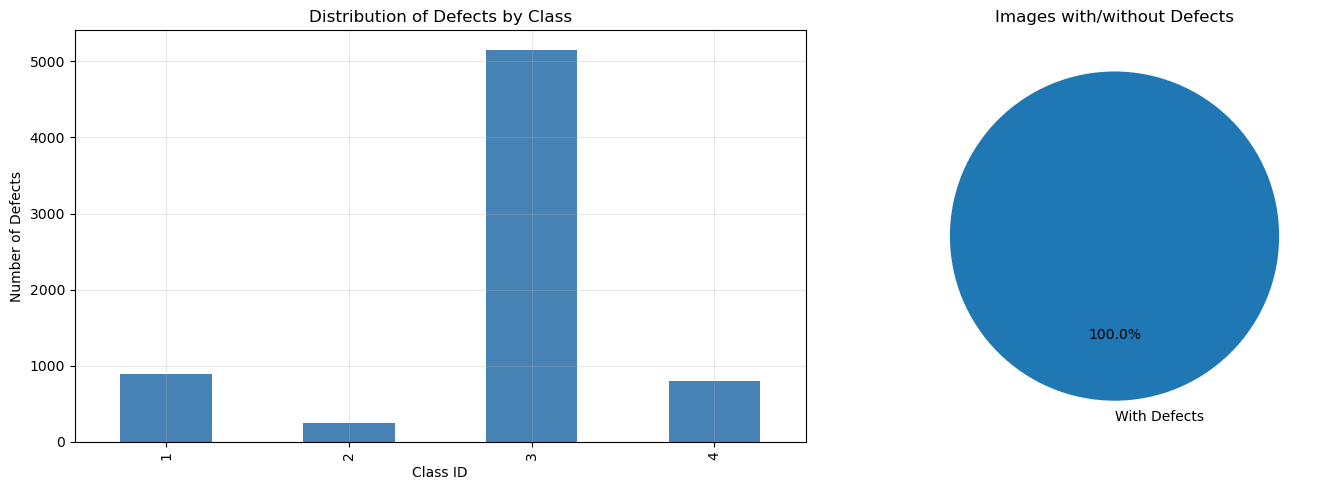


Images with at least one defect: 6666
Images with no defects: 0


In [42]:
# Visualize defect distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Defects by class
defect_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Class ID')
axes[0].set_ylabel('Number of Defects')
axes[0].set_title('Distribution of Defects by Class')
axes[0].grid(True, alpha=0.3)

# Images with/without defects
has_defect = train_df.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.notna().any())
defect_status = has_defect.value_counts()

# Only create pie chart if there are both categories
if len(defect_status) > 1:
    labels = ['With Defects', 'No Defects'] if defect_status.index[0] else ['No Defects', 'With Defects']
    axes[1].pie(defect_status, labels=labels, autopct='%1.1f%%', startangle=90)
else:
    # If all images have defects or all don't
    label = 'With Defects' if defect_status.index[0] else 'No Defects'
    axes[1].pie([defect_status.values[0]], labels=[label], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Images with/without Defects')

plt.tight_layout()
plt.show()

print(f"\nImages with at least one defect: {has_defect.sum()}")
print(f"Images with no defects: {(~has_defect).sum()}")

Visualizing sample image: 0002cc93b.jpg


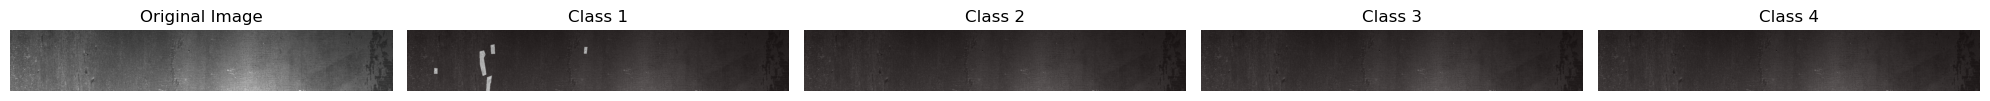

In [43]:
# Visualize sample images with defects
# Find images with defects for each class
sample_images = {}
for class_id in range(1, 5):
    images_with_class = train_df[(train_df['ClassId'] == class_id) & 
                                  (train_df['EncodedPixels'].notna())]['ImageId'].unique()
    if len(images_with_class) > 0:
        sample_images[class_id] = images_with_class[0]

# Visualize one sample with all classes
if sample_images:
    sample_image = list(sample_images.values())[0]
    print(f"Visualizing sample image: {sample_image}")
    visualize_sample(train_df, config.TRAIN_IMG_PATH, sample_image)

## 9. Prepare Data for Training

In [44]:
# Split data into train and validation
unique_images = train_df['ImageId'].unique()
train_images, valid_images = train_test_split(
    unique_images, 
    test_size=config.VALIDATION_SPLIT, 
    random_state=SEED
)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(valid_images)}")

# Create train and validation dataframes
train_data = train_df[train_df['ImageId'].isin(train_images)].reset_index(drop=True)
valid_data = train_df[train_df['ImageId'].isin(valid_images)].reset_index(drop=True)

print(f"\nTraining data shape: {train_data.shape}")
print(f"Validation data shape: {valid_data.shape}")

Training images: 5332
Validation images: 1334

Training data shape: (5670, 3)
Validation data shape: (1425, 3)


In [52]:
# Create datasets
train_transforms = get_train_transforms(config.IMG_HEIGHT, config.IMG_WIDTH)
valid_transforms = get_valid_transforms(config.IMG_HEIGHT, config.IMG_WIDTH)

train_dataset = SteelDataset(
    df=train_data,
    data_folder=config.TRAIN_IMG_PATH,
    phase='train',
    transforms=train_transforms
)

valid_dataset = SteelDataset(
    df=valid_data,
    data_folder=config.TRAIN_IMG_PATH,
    phase='train',
    transforms=valid_transforms
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Valid batches: {len(valid_loader)}")

Train dataset size: 5332
Valid dataset size: 1334

Train batches: 667
Valid batches: 167


## 10. Model Training

In [46]:
# Build model
model = build_model(
    encoder=config.ENCODER,
    encoder_weights=config.ENCODER_WEIGHTS,
    classes=config.CLASSES,
    activation=None  # We'll use sigmoid in loss function
)

model = model.to(device)
print(f"Model built and moved to {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model built and moved to cuda

Total parameters: 24,436,804
Trainable parameters: 24,436,804


In [48]:
# Define loss function, optimizer, and scheduler
criterion = BCEDiceLoss(smooth=1.0, bce_weight=0.5)
optimizer = Adam(model.parameters(), lr=config.LEARNING_RATE)
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3
)

print("Loss function, optimizer, and scheduler initialized!")

Loss function, optimizer, and scheduler initialized!


In [53]:
# Train the model
# Note: Set NUM_EPOCHS to a smaller value (e.g., 2-3) for quick testing
# For actual training, use 20-30 epochs

history = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=config.NUM_EPOCHS,
    device=device,
    model_path='best_steel_model.pth'
)


Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:37<00:00,  4.41it/s, loss=0.4808, dice=0.6773]




Train Loss: 0.6056 | Train Dice: 0.3760
Valid Loss: 0.4850 | Valid Dice: 0.7380
Learning Rate: 0.000100
✓ Model saved with Dice: 0.7380

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.61it/s, loss=0.4376, dice=0.8347]




Train Loss: 0.4657 | Train Dice: 0.8028
Valid Loss: 0.4437 | Valid Dice: 0.8725
Learning Rate: 0.000100
✓ Model saved with Dice: 0.8725

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.61it/s, loss=0.4298, dice=0.8817]



Train Loss: 0.4463 | Train Dice: 0.8408
Valid Loss: 0.4335 | Valid Dice: 0.8704
Learning Rate: 0.000100

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.51it/s, loss=0.4345, dice=0.8301]




Train Loss: 0.4400 | Train Dice: 0.8401
Valid Loss: 0.4316 | Valid Dice: 0.8825
Learning Rate: 0.000100
✓ Model saved with Dice: 0.8825

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.65it/s, loss=0.4318, dice=0.8340]



Train Loss: 0.4375 | Train Dice: 0.8290
Valid Loss: 0.4292 | Valid Dice: 0.8731
Learning Rate: 0.000100

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.75it/s, loss=0.4199, dice=0.8498]



Train Loss: 0.4348 | Train Dice: 0.8482
Valid Loss: 0.4262 | Valid Dice: 0.8669
Learning Rate: 0.000100

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.60it/s, loss=0.0519, dice=0.9306]




Train Loss: 0.2867 | Train Dice: 0.8724
Valid Loss: 0.0762 | Valid Dice: 0.9047
Learning Rate: 0.000100
✓ Model saved with Dice: 0.9047

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:37<00:00,  4.51it/s, loss=0.0547, dice=0.9189]



Train Loss: 0.0783 | Train Dice: 0.8964
Valid Loss: 0.0726 | Valid Dice: 0.9033
Learning Rate: 0.000100

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.64it/s, loss=0.0530, dice=0.9234]




Train Loss: 0.0756 | Train Dice: 0.8974
Valid Loss: 0.0703 | Valid Dice: 0.9058
Learning Rate: 0.000100
✓ Model saved with Dice: 0.9058

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.65it/s, loss=0.0503, dice=0.9272]



Train Loss: 0.0745 | Train Dice: 0.8982
Valid Loss: 0.0708 | Valid Dice: 0.9051
Learning Rate: 0.000100

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.63it/s, loss=0.0431, dice=0.9370]



Train Loss: 0.0732 | Train Dice: 0.9002
Valid Loss: 0.0704 | Valid Dice: 0.9049
Learning Rate: 0.000100

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.67it/s, loss=0.0444, dice=0.9411]



Train Loss: 0.0727 | Train Dice: 0.8997
Valid Loss: 0.0709 | Valid Dice: 0.9050
Learning Rate: 0.000100

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.67it/s, loss=0.0477, dice=0.9278]




Train Loss: 0.0725 | Train Dice: 0.9004
Valid Loss: 0.0690 | Valid Dice: 0.9067
Learning Rate: 0.000100
✓ Model saved with Dice: 0.9067

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.66it/s, loss=0.0384, dice=0.9457]




Train Loss: 0.0717 | Train Dice: 0.9011
Valid Loss: 0.0676 | Valid Dice: 0.9091
Learning Rate: 0.000100
✓ Model saved with Dice: 0.9091

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.68it/s, loss=0.0395, dice=0.9416]



Train Loss: 0.0713 | Train Dice: 0.9014
Valid Loss: 0.0675 | Valid Dice: 0.9084
Learning Rate: 0.000100

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.65it/s, loss=0.0480, dice=0.9290]



Train Loss: 0.0708 | Train Dice: 0.9016
Valid Loss: 0.0683 | Valid Dice: 0.9080
Learning Rate: 0.000100

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.67it/s, loss=0.0517, dice=0.9246]



Train Loss: 0.0704 | Train Dice: 0.9028
Valid Loss: 0.0678 | Valid Dice: 0.9080
Learning Rate: 0.000100

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.65it/s, loss=0.0540, dice=0.9192]



Train Loss: 0.0702 | Train Dice: 0.9028
Valid Loss: 0.0675 | Valid Dice: 0.9088
Learning Rate: 0.000100

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.68it/s, loss=0.0459, dice=0.9322]




Train Loss: 0.0697 | Train Dice: 0.9037
Valid Loss: 0.0670 | Valid Dice: 0.9091
Learning Rate: 0.000100
✓ Model saved with Dice: 0.9091

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.67it/s, loss=0.0468, dice=0.9288]




Train Loss: 0.0700 | Train Dice: 0.9035
Valid Loss: 0.0669 | Valid Dice: 0.9098
Learning Rate: 0.000100
✓ Model saved with Dice: 0.9098

Epoch 21/30
--------------------------------------------------
✓ Model saved with Dice: 0.9098

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.67it/s, loss=0.0450, dice=0.9335]




Train Loss: 0.0692 | Train Dice: 0.9041
Valid Loss: 0.0663 | Valid Dice: 0.9105
Learning Rate: 0.000100
✓ Model saved with Dice: 0.9105

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.67it/s, loss=0.0437, dice=0.9365]



Train Loss: 0.0690 | Train Dice: 0.9045
Valid Loss: 0.0662 | Valid Dice: 0.9101
Learning Rate: 0.000100

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.66it/s, loss=0.0527, dice=0.9241]



Train Loss: 0.0681 | Train Dice: 0.9057
Valid Loss: 0.0666 | Valid Dice: 0.9098
Learning Rate: 0.000100

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.64it/s, loss=0.0476, dice=0.9265]



Train Loss: 0.0686 | Train Dice: 0.9049
Valid Loss: 0.0669 | Valid Dice: 0.9095
Learning Rate: 0.000100

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.62it/s, loss=0.0460, dice=0.9321]




Train Loss: 0.0676 | Train Dice: 0.9059
Valid Loss: 0.0658 | Valid Dice: 0.9111
Learning Rate: 0.000100
✓ Model saved with Dice: 0.9111

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.63it/s, loss=0.0394, dice=0.9456]



Train Loss: 0.0675 | Train Dice: 0.9065
Valid Loss: 0.0660 | Valid Dice: 0.9106
Learning Rate: 0.000100

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.64it/s, loss=0.0456, dice=0.9318]



Train Loss: 0.0672 | Train Dice: 0.9067
Valid Loss: 0.0668 | Valid Dice: 0.9102
Learning Rate: 0.000100

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:35<00:00,  4.65it/s, loss=0.0384, dice=0.9442]



Train Loss: 0.0666 | Train Dice: 0.9076
Valid Loss: 0.0666 | Valid Dice: 0.9097
Learning Rate: 0.000100

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.63it/s, loss=0.0425, dice=0.9359]




Train Loss: 0.0673 | Train Dice: 0.9069
Valid Loss: 0.0651 | Valid Dice: 0.9117
Learning Rate: 0.000100
✓ Model saved with Dice: 0.9117

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 167/167 [00:36<00:00,  4.62it/s, loss=0.0505, dice=0.9262]


Train Loss: 0.0666 | Train Dice: 0.9076
Valid Loss: 0.0666 | Valid Dice: 0.9095
Learning Rate: 0.000100

Best Validation Dice: 0.9117


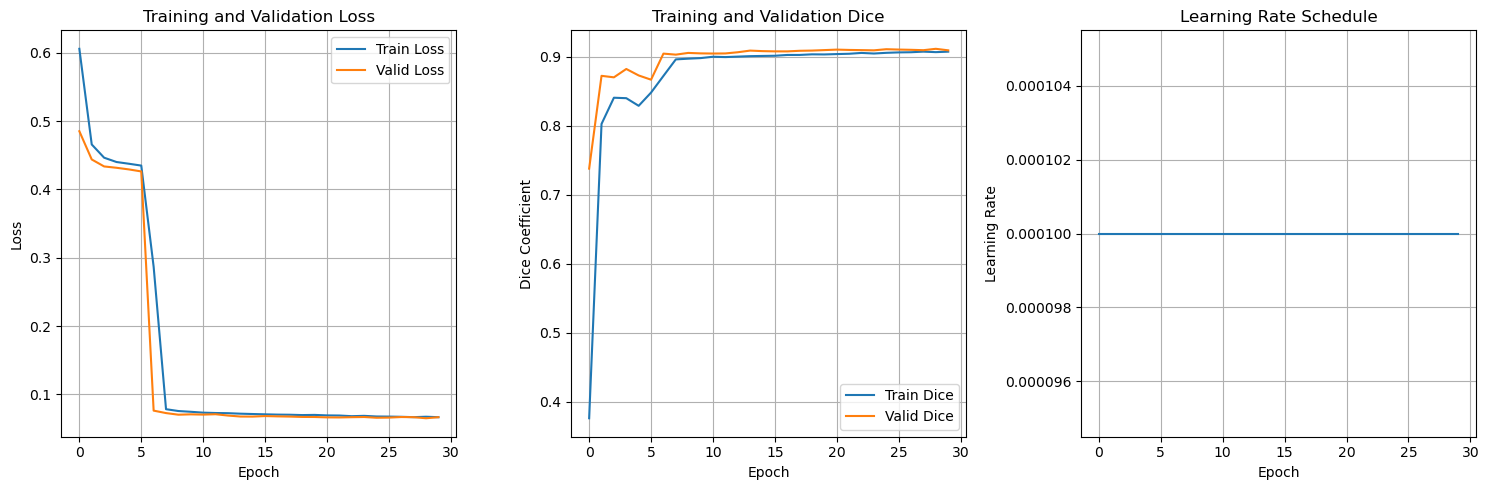

In [55]:
# Plot training history
plot_training_history(history)

## 11. Validation Set Predictions

Best model loaded!


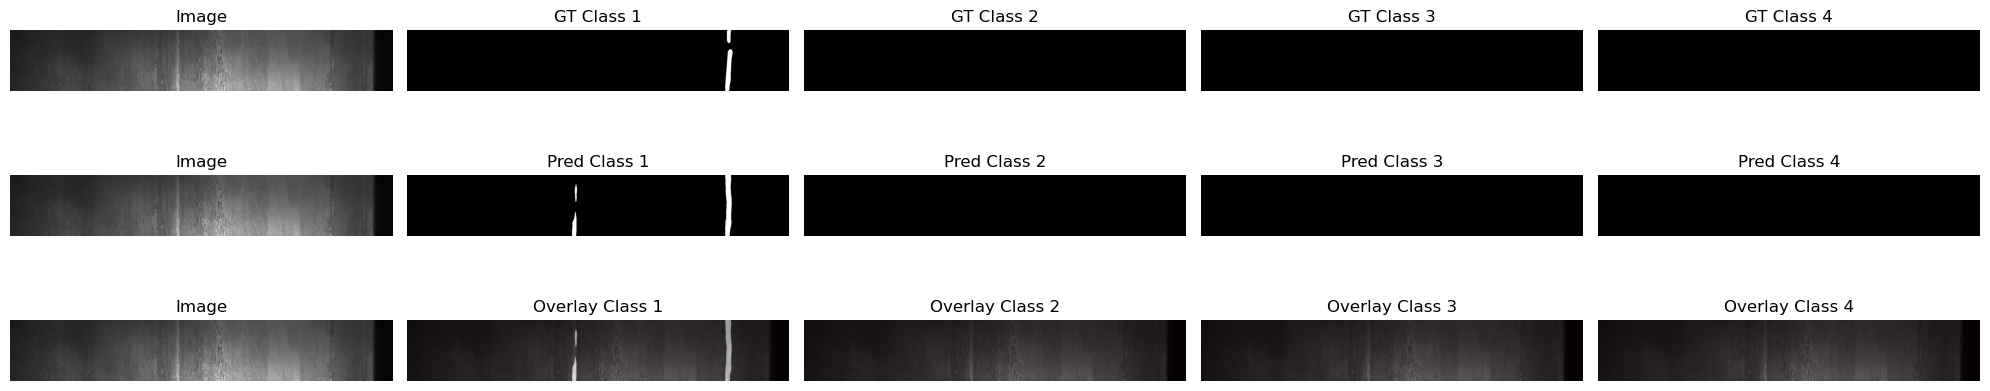

In [56]:
# Load best model
model.load_state_dict(torch.load('best_steel_model.pth'))
model.eval()
print("Best model loaded!")

# Visualize predictions on validation set
sample_idx = np.random.randint(0, len(valid_dataset))
image, true_mask = valid_dataset[sample_idx]

# Make prediction
with torch.no_grad():
    image_tensor = image.unsqueeze(0).to(device)
    output = model(image_tensor)
    pred_mask = torch.sigmoid(output).cpu().numpy()[0]

# Convert to binary
pred_mask_binary = (pred_mask > 0.5).astype(np.float32)

# Visualize
visualize_predictions(image, true_mask, pred_mask_binary)

## 12. Test Set Predictions and Submission

In [60]:
# Load sample submission to get test image names
# Read fresh from file to avoid conflicts with previous modifications
sample_sub_df = pd.read_csv(config.SAMPLE_SUBMISSION)

# Get unique test images (ImageId column already exists in the CSV)
test_images = sample_sub_df['ImageId'].unique()
print(f"Number of test images: {len(test_images)}")

# Create test dataframe
test_df = pd.DataFrame({'ImageId': test_images})

# Create test dataset
test_transforms = get_test_transforms(config.IMG_HEIGHT, config.IMG_WIDTH)

test_dataset = SteelDataset(
    df=test_df,
    data_folder=config.TEST_IMG_PATH,
    phase='test',
    transforms=test_transforms
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")

Number of test images: 5506
Test dataset size: 5506
Test batches: 689


In [61]:
# Generate predictions
test_predictions = predict(model, test_loader, device, threshold=0.5)
print(f"Generated predictions for {len(test_predictions)} images")

Predicting: 100%|██████████| 689/689 [02:20<00:00,  4.92it/s]

Generated predictions for 5506 images


In [62]:
# Create submission file
submission = generate_submission(
    predictions=test_predictions,
    sample_submission_path=config.SAMPLE_SUBMISSION,
    output_path='submission.csv',
    threshold=0.5,
    min_size=3500
)

# Display first few rows
print("\nSubmission preview:")
print(submission.head(20))

Generating submission: 100%|██████████| 5506/5506 [00:31<00:00, 172.85it/s]

Submission saved to submission.csv

Submission preview:
    ImageId_ClassId EncodedPixels
0   0000f269f.jpg_0              
1   000ccc2ac.jpg_0              
2   002451917.jpg_0              
3   003c5da97.jpg_0              
4   0042e163f.jpg_0              
5   004f40c73.jpg_0              
6   00513039a.jpg_0              
7   006f39c41.jpg_0              
8   008725cbc.jpg_0              
9   0098ca44e.jpg_0              
10  00a0b7730.jpg_0              
11  00a0f9949.jpg_0              
12  00b000b81.jpg_0              
13  00b7fb703.jpg_0              
14  00bbcd9af.jpg_0              
15  00d72c660.jpg_0              
16  00df5b714.jpg_0              
17  00f3799a7.jpg_0              
18  0108ce457.jpg_0              
19  0109b68ec.jpg_0              


## 13. Summary and Next Steps

### What We've Built:
1. **Data Loading**: RLE encoding/decoding for segmentation masks
2. **Data Augmentation**: Comprehensive augmentation pipeline using Albumentations
3. **Model**: U-Net architecture with ResNet34 encoder
4. **Training**: BCE + Dice Loss with learning rate scheduling
5. **Evaluation**: Dice coefficient metric
6. **Submission**: RLE-encoded predictions

### Key Features:
- Multi-class segmentation for 4 defect types
- State-of-the-art U-Net architecture with pretrained encoder
- Combined loss function (BCE + Dice) for better segmentation
- Post-processing to remove small false positives
- Proper train/validation split

### Potential Improvements:
1. **Model Enhancements**:
   - Try different encoders (ResNet50, EfficientNet, etc.)
   - Experiment with U-Net++, FPN, or DeepLabV3+
   - Ensemble multiple models

2. **Data Augmentation**:
   - Test Time Augmentation (TTA)
   - More aggressive augmentations
   - Class-specific augmentations

3. **Post-processing**:
   - Optimize threshold values per class
   - Adjust minimum object size per class
   - Morphological operations

4. **Training**:
   - Longer training with early stopping
   - Different learning rate schedules
   - Class balancing or weighted loss

5. **Cross-Validation**:
   - K-fold cross-validation for robust evaluation
   - Stratified splitting based on defect presence

### Usage:
- Adjust `NUM_EPOCHS` in config for quick testing (2-3) or full training (20-30)
- Modify threshold and min_size in submission generation for better results
- Experiment with different model architectures by changing the encoder